In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit

In [2]:
def input_data(Nx,Ny,rmin):
    
    #Nx= Nuber of elements in X dire
    #Ny= Number of elements in Y dire
    #NN= Array with node numbers( Ny+1,Nx+1)
    #dom= Array with co-ordiantes of all nodes iwth X- row and Y- column
    #XDOF= DOF matrix(Ny+1,Nx+1) contains DOF in X dir
    #YDOF= DOF matrix(Ny+1,Nx+1) contains DOF in Y dir
    
    
    X=np.linspace(0,Nx,Nx+1);
    Y=np.linspace(0,Ny,Ny+1);
    dom=np.empty((Ny+1,Nx+1), dtype=object);
    
    
    for i in range(0,Ny+1):
        for j in range(0,Nx+1):
            dom[i,j]=(X[j],Y[i])
    
    
            
    n=np.linspace(1,(Nx+1)*(Ny+1),((Nx+1)*(Ny+1)));# total number of nodes
    
    NN=np.reshape(n,(Ny+1,Nx+1)).T;# n is reshape to get nodal matrix
    #DOF=np.linspace(1,2*(Nx+1)*(Ny+1),2*(Nx+1)*(Ny+1));
    #XDOF=DOF[0:2*(Nx+1)*(Ny+1)-1:2].reshape(Ny+1,Nx+1);
    #YDOF=DOF[1:2*(Nx+1)*(Ny+1):2].reshape(Ny+1,Nx+1);

        
    # Element matrix
    # Element=[Nx*Ny,4]: Num of elements X 4 node_numbers
    Element=np.zeros((Ny*Nx,4));
    Element_DOF=np.zeros((Ny*Nx,8));
    Element_cen=np.empty((Ny*Nx), dtype=object)
    k=0;
    for i  in range (0,Ny):
        for j in range (0,Nx):
            
            Element[k,:]=[NN[i+1,j], NN[i+1,j+1] ,NN[i,j+1] ,NN[i,j] ]
            
            Element_DOF[k,:]=[ NN[i+1,j]*2-1, NN[i+1,j]*2, NN[i+1,j+1]*2-1, NN[i+1,j+1]*2,NN[i,j+1]*2-1,NN[i,j+1]*2,NN[i,j]*2-1,NN[i,j]*2]
            k=k+1;
    

    for i in range (0, Nx*Ny):
        
        P0=dom[np.where(NN==Element[i,0])[0],np.where(NN==Element[i,0])[1]]
        P1=dom[np.where(NN==Element[i,1])[0],np.where(NN==Element[i,1])[1]]
        P2=dom[np.where(NN==Element[i,2])[0],np.where(NN==Element[i,2])[1]]
        P3=dom[np.where(NN==Element[i,3])[0],np.where(NN==Element[i,3])[1]]
        Element_cen[i]= (np.average([P0[0][0],P1[0][0],P2[0][0],P3[0][0]]),np.average([P0[0][1],P1[0][1],P2[0][1],P3[0][1]]))
    
    H_ele=np.zeros((Nx*Ny,Nx*Ny))
    
    for i in range (0, Nx*Ny):
        for j in range(0,Nx*Ny):
            X0=Element_cen[i][0]
            X1=Element_cen[j][0]
            Y0=Element_cen[i][1]
            Y1=Element_cen[j][1]
            r= np.sqrt((Y1-Y0)**2+(X1-X0)**2)
            if r<=rmin:
                H_ele[j,i]=rmin-r
                              
    return NN,Element_DOF,H_ele


def Stiffness_local(nu):
    # As dimensions of all elements are same, Local stiffness matrix for every element will be same
    #KE is generated for the plane stress elements.
    
    A11=np.array([[12,3 ,-6 ,-3], [3 ,12, 3, 0], [-6 ,3, 12, -3],[-3 ,0 ,-3, 12]]);
    A12=np.array([[-6, -3 ,0 ,3], [-3 ,-6, -3, -6],[ 0, -3, -6 ,3],[3 ,-6, 3, -6]]);
    B11=np.array([[-4, 3 ,-2, 9],[3, -4 ,-9 ,4], [-2, -9 ,-4 ,-3], [9, 4, -3, -4]]);
    B12=np.array([[2, -3, 4, -9],[-3, 2 ,9, -2] , [4, 9, 2, 3], [-9, -2, 3, 2]]);
    A=np.concatenate((A11 ,A12),axis=1)
    B=np.concatenate((A12.T ,A11),axis=1)
    C=np.concatenate((A ,B),axis=0)
    A=np.concatenate((B11, B12),axis=1)
    B=np.concatenate((B12.T ,B11),axis=1)
    D=np.concatenate((A ,B),axis=0)
    
    KE=(1/(24*(1-nu*nu)))*(C+ nu*D);
                           
    return KE


def Global_Stifffness(K_local, Element_DOF,NN,density):
    
    X=density.reshape((Nx*Ny,))
    X=Emin+(X**penal)*(Eo-Emin)
    KG=np.zeros(((2*NN.shape[0]*NN.shape[1]),(2*NN.shape[0]*NN.shape[1])));
    #print(KG.shape)
    for ele in range (Nx*Ny):
        p_indices = Element_DOF[ele,:].astype(int)-1
        KG[np.ix_(p_indices, p_indices)] += X[ele] * K_local
       
    return KG


def BC(Node, Node_DOF):
    #func: This fucntion takes all the nodes and nodes_DOF and gives the segregated DOF as per Sigmund(99 code)
    #input= Node( all nodes of structure), Node_DOF= All DOF of th nodes
    
    D1=np.array([Node[0,0]*2-1,Node[0,0]*2, Node[0,-1]*2-1,Node[0,-1]*2,Node[-1,-1]*2-1,Node[-1,-1]*2,Node[-1,0]*2-1,Node[-1,0]*2])
    nd3=np.concatenate((Node[1:-1,-1],Node[ 0,1:-1]),axis=0)
    a=[[2*i-1,2*i] for i in nd3]
    aa=[]
    for i in range(len(a)):
        aa=aa+a[i]
    D3=np.array(aa)
    nd4=np.concatenate((Node[1:-1,0],Node[-1,1:-1]),axis=0)
    a=[[2*i-1,2*i] for i in nd4]
    aa=[]
    for i in range(len(a)):
        aa=aa+a[i]
    D4=np.array(aa)
    D4_flattened=D4.flatten()
    D3_flattened=D3.flatten()
    D1_flattened=D1.flatten()
    D134=np.concatenate((D1_flattened,D4_flattened,D3_flattened))
    D2=np.setdiff1d(Node_DOF, D134)
    D3dup=D4.copy()
    D4=D3
    D3=D3dup
    
    return D1,D2,D3,D4

def PBC(Nx,Ny):
    #func: This fucntion generated the dispalcement at four nodes and for edge nodes as per unti strain field
    #input=NIL
    #output= Displacement of four corner nodes and edge nodes that eprtain the ( D3/D4)
    #brief: This function evaluates the displacement for a unit cell for a unit strain field
    #[0 1 2 3 4 5 6 7],[2,3]= top right edge node,[4,5]= diagonal node,[6,7]: Y direction node
    
    NNx=Nx-1 # indicates the number of nodes in the edges apart from the end nodes
    NNy=Ny-1
    eo=np.array([[1,0,0],[0,1,0],[0,0,1]]) # unit strain field
    U=np.zeros((8,3))
    for j in range(3):
        
        U[4:6,j]=np.dot(np.array([[eo[0,j],eo[2,j]*0.5],[eo[2,j]*0.5,eo[1,j]]]),np.array([[Nx],[0]])).reshape(1,-1)
        U[0:2,j]=np.dot(np.array([[eo[0,j],eo[2,j]*0.5],[eo[2,j]*0.5,eo[1,j]]]),np.array([[0],[Ny]])).reshape(1,-1)
        U[2:4,j]=U[4:6,j]+ U[0:2,j]
    
    wfixed=np.zeros(((NNx)*2+(NNy)*2,3))
    for i in range(0,2*NNx,2):
        wfixed[i,:]=U[4,:]
    
    for i in range(1,2*NNx,2):
        wfixed[i,:]=U[5,:]
      
    for i in range(0,2*NNy,2):
        wfixed[i+2*NNx,:]=U[0,:]
    
    for i in range(1,2*NNy,2):
        wfixed[i+2*NNx,:]=U[1,:] 
        
    
    return U, wfixed

def analysis(U1,wfixed,D_1,D_2,D_3,D_4,K_add):

    D1=D_1.copy().astype(int)-1
    D2=D_2.copy().astype(int)-1
    D3=D_3.copy().astype(int)-1
    D4=D_4.copy().astype(int)-1

    K22=K_add[D2,:][:,D2]
    K23=K_add[D2,:][:,D3]
    K24=K_add[D2,:][:,D4]
    K33=K_add[D3,:][:,D3]
    K34=K_add[D3,:][:,D4]
    K43=K_add[D4,:][:,D3]
    K44=K_add[D4,:][:,D4]
    K21=K_add[D2,:][:,D1]
    K31=K_add[D3,:][:,D1]
    K41=K_add[D4,:][:,D1]
    K32=K_add[D3,:][:,D2]
    K42=K_add[D4,:][:,D2]
    
    K1=np.concatenate((K22,K23+K24),axis=1)
    K2=np.concatenate((K32+K42,K33+K34+K43+K44),axis=1)
    K_new=np.concatenate((K1,K2),axis=0)
    K_U1=np.concatenate((K21,K31+K41),axis=0)
    K_W1=np.concatenate((K24,K34+K44),axis=0)
    
    U23=np.zeros((D2.shape[0]+D3.shape[0],3))

    
    A = -(np.dot(K_U1, U1) + np.dot(K_W1, wfixed))
    K_inv = np.linalg.inv(K_new)
    U23 = np.dot(K_inv, A)
    
    disp=np.zeros(((Nx+1)*(Ny+1)*2,3))
    
    disp[D1,:]=U1
    disp[D2,:]=U23[0:D2.shape[0],:]
    disp[D3,:]=U23[D2.shape[0]:,:]
    disp[D4,:]=U23[D2.shape[0]:,:]+wfixed

        
    return disp


def initial_Density(Nx,Ny,volfrac):
    #brief: This function evaluates the initial density of the 2D material. It is coded as softer material at center 
    #and harder material on the outer face
    #it evaluates the distance between the center of eleement to center of domain and it should be less than 1/3 rd of the 
    #total length
    X= np.zeros((Ny,Nx))
    for i in range(Nx):
        for j in range(Ny):
            if np.sqrt((j+0.5-Ny*0.5)**2+(i+0.5-Nx*0.5)**2)<(np.minimum(Nx,Ny)/3):
                X[j,i]=volfrac*0.5
            else:
                X[j,i]=volfrac
    return X

def strain_energy(disp,Element_DOF,density):
    
    X=density.reshape((Nx*Ny,))
    
    # calculation of element stiffness matrix
    DOF=Element_DOF.copy()-1
    DOF=DOF.astype(int)
    K_e=Stiffness_local(nu)
    
    # initialization of mutual energies
    q=np.zeros((Ny*Nx,))
    dQ=np.zeros((Ny*Nx,9))
    #dq= matrix containing all the energies for elements for particualr strain
    #dq[:,0]: referes to the energies of elements corresponding to E11
    #dq[:,1]:E12, dq[:,2]:E13
    
    Q=np.zeros((3,3))
    kk=0
    for i in range(3):
        for j in range(3):
            for element in range(Nx*Ny):
                UTK=np.dot(disp[DOF[element,:],i].T,K_e)
                q[element]=np.dot(UTK,disp[DOF[element,:],j])/(Nx*Ny)
                dQ[element,kk]=q[element]*(penal*(Eo-Emin)*X[element]**(penal-1))               
                q[element]=q[element]*(Emin+(X[element]**penal)*(Eo-Emin))
            # THis is meant for calculation of C(compliance)
            Q[i,j]=np.sum(q)
            kk=kk+1
    
    # from this line calcualtion of C, dC and dV commences
   
    #C=Q[0,1]-((0.8**loop)*(Q[0,0]+Q[1,1]))
    C=-(Q[0,0]+Q[0,1]+Q[1,1]+Q[1,0])
    #dC=dQ[:,1]-((0.8**loop)*(dQ[:,0]+dQ[:,4]))
    dC=-(dQ[:,0]+dQ[:,1]+dQ[:,3]+dQ[:,4])
    
    dV=np.ones((Nx*Ny,))
    
    return C,dC,dV
    
    
def filteration(C_der,V_der,H_ele,density):
    X=density.copy().reshape((Nx*Ny,))
    B=np.full((Ny*Nx,),1e-3)
    dC=np.zeros((Ny*Nx,))
    
    if ft==1:
        for i in range(Nx*Ny):
            H_sum=np.sum(H_ele[:,i])
            dC[i]=np.sum(C_der*H_ele[:,i]*X)/(np.maximum(1e-9,X[i]))
            dC[i]=dC[i]/H_sum
        
    elif ft==2:
        for i in range(Nx*Ny):
            H_sum=np.sum(H_ele[:,i])
            C_der=C_der*H_ele[:,i]/H_sum
            V_der=V_der*H_ele[:,i]/H_sum
    elif ft==0:
        C_der=C_der
        V_der=V_der
        
    return dC,V_der
        
    
def optimal_criteria(C_der,V_der,den,H_ele):
    Xd=den.copy().reshape((Nx*Ny,))
    move=0.3
    l1=0
    l2=1E+9
    f1=np.ones((Xd.shape[0],))
    f0=np.zeros((Xd.shape[0],))
    while (l2-l1)>1e-9:
        lmid=0.5*(l1+l2)
        Be=-dC/(dV*lmid)
        a=np.minimum(Xd+move,Xd*np.sqrt(-C_der/(V_der*lmid)))
        b=np.minimum(f1,a)
        c=np.maximum(Xd-move,b)
        Xd_new=np.maximum(f0,c)
        
        if np.mean(Xd_new) > volfrac:
            l1=lmid
        else:
            l2=lmid
  
  
                
    if ft==1:
        Xd_new=Xd_new
    elif ft==2:
        for i in range(Nx*Ny):
                H_sum=np.sum(H_ele[:,i])
                Xd_new=Xd_new*H_ele[:,i]/H_sum
    else:
        Xd_new=Xd_new
        
    Xd_new=Xd_new.reshape((Ny,Nx))
    
    return Xd_new
                
            

Loop:1 change :0.2535944893305162 mean_Density : 0.5000004448364083 Compliance :-0.1827900961371056


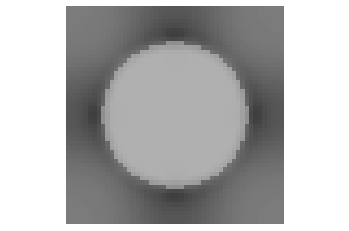

Loop:2 change :0.12212035583626679 mean_Density : 0.499999730120451 Compliance :-0.32978000281455266


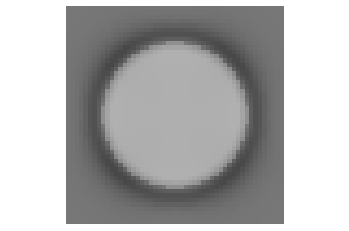

Loop:3 change :0.12523540811114664 mean_Density : 0.5000000656846234 Compliance :-0.3345814896746832


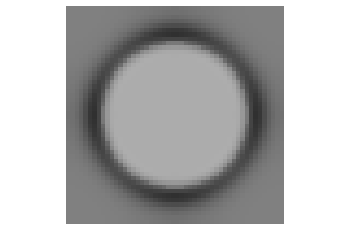

Loop:4 change :0.10386912466234632 mean_Density : 0.5000000380882819 Compliance :-0.3391791744198278


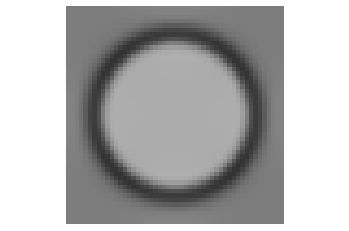

Loop:5 change :0.10750937445396724 mean_Density : 0.5000000737326565 Compliance :-0.3426317493567538


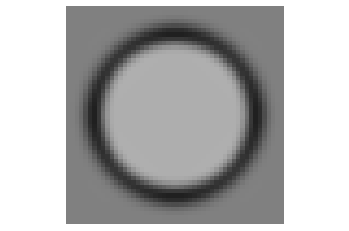

Loop:6 change :0.09641544460398699 mean_Density : 0.49999989934835515 Compliance :-0.34627515918153295


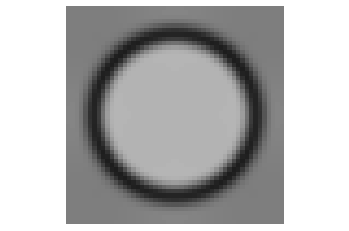

Loop:7 change :0.12277498255210506 mean_Density : 0.5000001071959509 Compliance :-0.35303349223382924


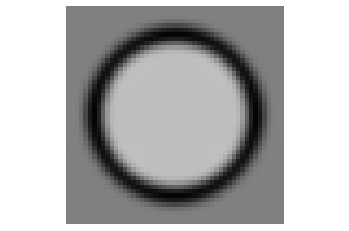

Loop:8 change :0.14228665351801273 mean_Density : 0.5000001768180664 Compliance :-0.36925244225247983


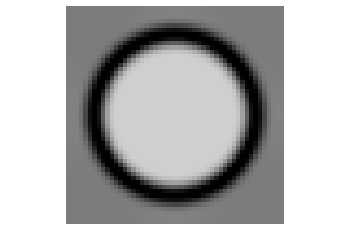

Loop:9 change :0.1281364583371455 mean_Density : 0.5000001008796868 Compliance :-0.40463094057315696


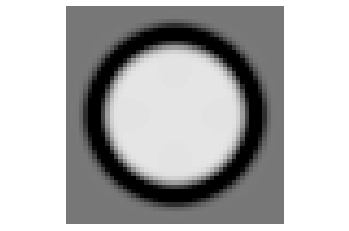

Loop:10 change :0.11110002739444014 mean_Density : 0.4999998518353321 Compliance :-0.45434565705113505


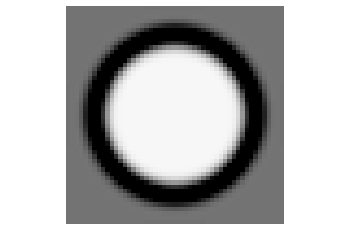

Loop:11 change :0.071812818497615 mean_Density : 0.49999996545132364 Compliance :-0.5003343299731536


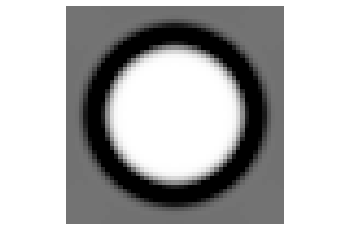

Loop:12 change :0.05399583474345249 mean_Density : 0.49999996973401795 Compliance :-0.5188404834527489


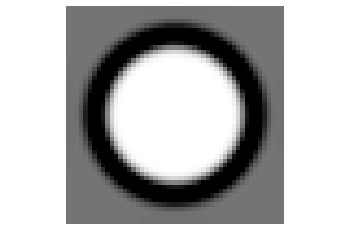

Loop:13 change :0.04230635326029608 mean_Density : 0.49999999832167025 Compliance :-0.5196571307008375


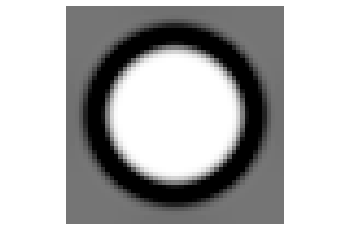

Loop:14 change :0.039715269046985635 mean_Density : 0.5000000036132579 Compliance :-0.5180991339073123


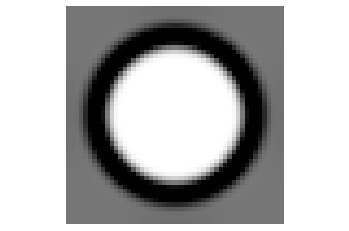

Loop:15 change :0.03952554956776222 mean_Density : 0.4999998756522433 Compliance :-0.5164541782204725


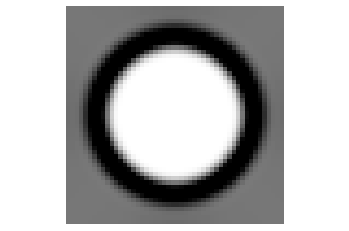

Loop:16 change :0.03953190870372314 mean_Density : 0.4999999546328668 Compliance :-0.5146880911527527


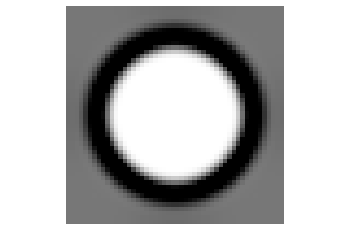

Loop:17 change :0.03999723110738407 mean_Density : 0.4999999002245022 Compliance :-0.5129590534363717


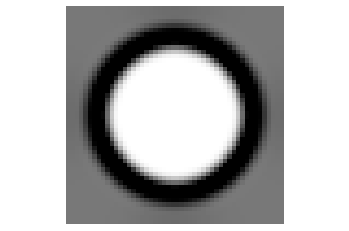

Loop:18 change :0.03886475685222168 mean_Density : 0.500000027808728 Compliance :-0.5109919171949864


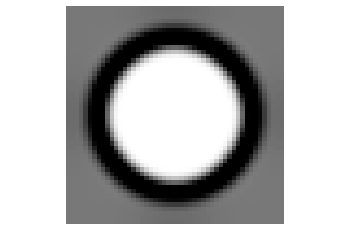

Loop:19 change :0.03663775775001876 mean_Density : 0.4999999441787653 Compliance :-0.5088795119511054


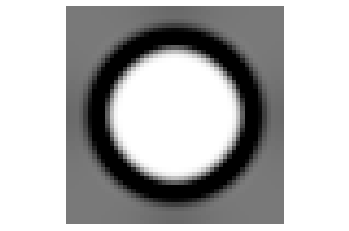

Loop:20 change :0.03431409266565477 mean_Density : 0.5000000003040297 Compliance :-0.5068601433281739


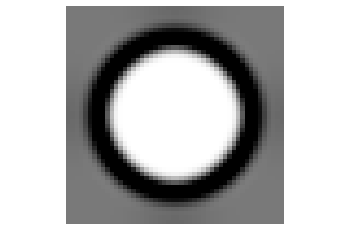

Loop:21 change :0.03298561912504172 mean_Density : 0.5000000359192107 Compliance :-0.5049186870850357


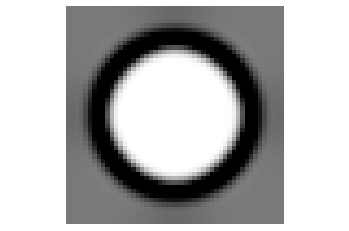

Loop:22 change :0.03275157129928852 mean_Density : 0.4999999379498462 Compliance :-0.5031093149626411


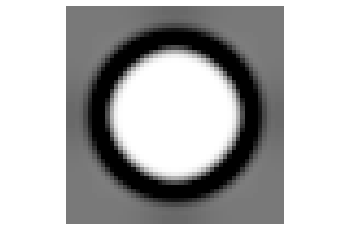

Loop:23 change :0.031720463395396026 mean_Density : 0.5000000315044153 Compliance :-0.5013662278841018


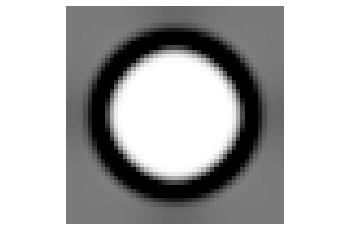

Loop:24 change :0.031260490418440146 mean_Density : 0.49999999926794947 Compliance :-0.499620158736933


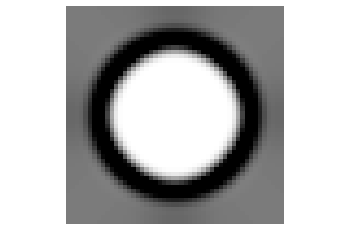

Loop:25 change :0.031239486405158834 mean_Density : 0.5000001023209878 Compliance :-0.4979806890940181


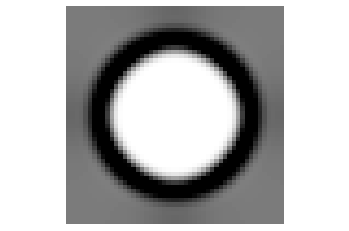

Loop:26 change :0.030257740780601394 mean_Density : 0.499999936274191 Compliance :-0.4963031140841059


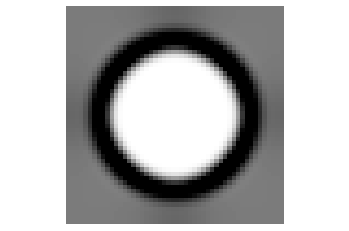

Loop:27 change :0.029113310464248587 mean_Density : 0.5000001264885338 Compliance :-0.4946623902263636


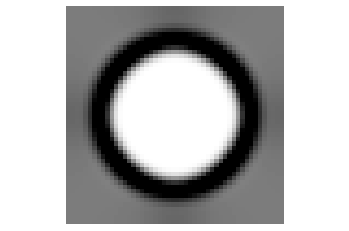

Loop:28 change :0.02786063994958643 mean_Density : 0.500000101461007 Compliance :-0.49301842186127404


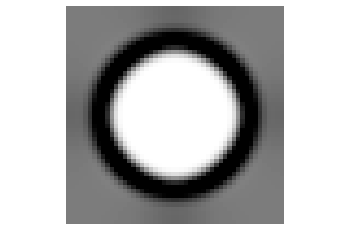

Loop:29 change :0.026791972704806155 mean_Density : 0.4999998814630684 Compliance :-0.4914586924057436


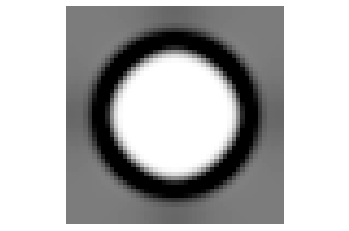

Loop:30 change :0.02556511604108258 mean_Density : 0.5000000600202523 Compliance :-0.48994713409466534


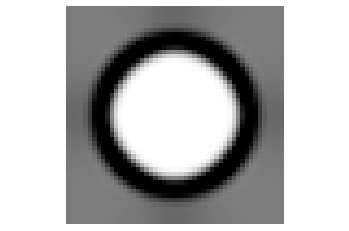

Loop:31 change :0.0250112378079812 mean_Density : 0.5000001273892444 Compliance :-0.488527251333408


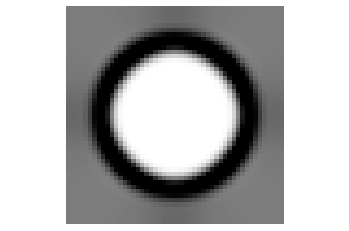

Loop:32 change :0.024333659306234323 mean_Density : 0.5000000300188253 Compliance :-0.487176396156028


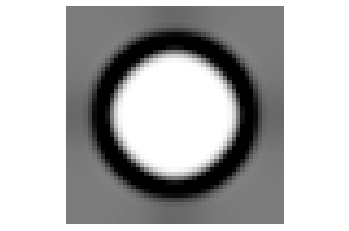

Loop:33 change :0.025014846229800436 mean_Density : 0.499999909168239 Compliance :-0.4858928051260522


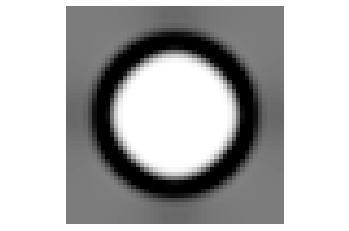

Loop:34 change :0.025848499561294758 mean_Density : 0.5000000027098185 Compliance :-0.48459183085901086


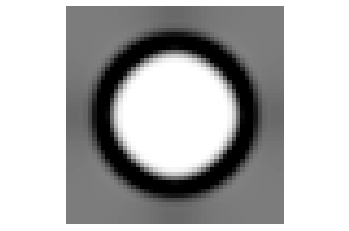

Loop:35 change :0.025755082949071806 mean_Density : 0.5000001420399459 Compliance :-0.4833419386853012


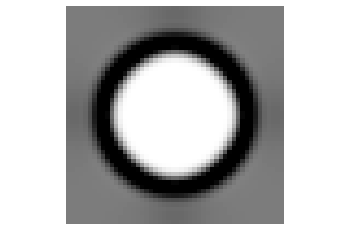

Loop:36 change :0.025683396024376637 mean_Density : 0.5000001384249004 Compliance :-0.4821710039889491


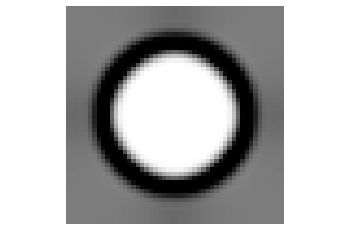

Loop:37 change :0.025651763017684237 mean_Density : 0.4999999483570895 Compliance :-0.48096068168523


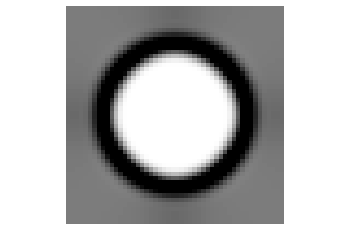

Loop:38 change :0.024913151311181658 mean_Density : 0.5000000892126484 Compliance :-0.47972532334942686


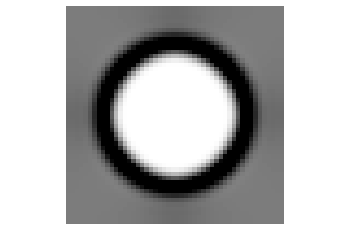

Loop:39 change :0.02489349715420286 mean_Density : 0.5000000862552327 Compliance :-0.4784854901666255


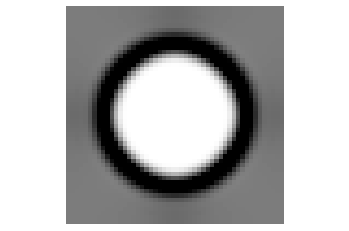

Loop:40 change :0.024293809215989337 mean_Density : 0.4999998723081887 Compliance :-0.4772635920964147


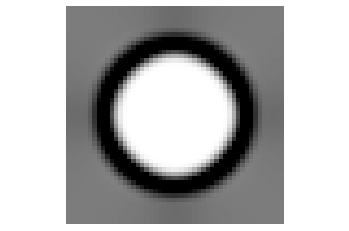

Loop:41 change :0.022734238575661925 mean_Density : 0.4999999625620607 Compliance :-0.4759746028936467


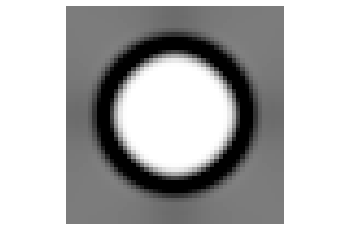

Loop:42 change :0.021550565035843405 mean_Density : 0.4999999341180892 Compliance :-0.47465769681447467


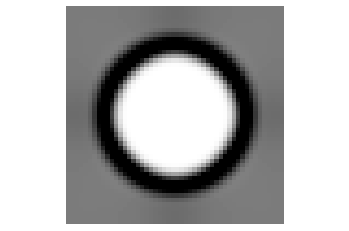

Loop:43 change :0.021007980622301692 mean_Density : 0.4999999565557165 Compliance :-0.4733928817011064


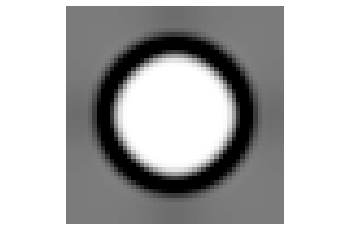

Loop:44 change :0.02130496609124022 mean_Density : 0.5000000100476889 Compliance :-0.47220198390037893


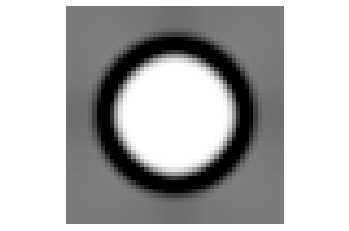

Loop:45 change :0.02145688865200801 mean_Density : 0.49999998381314836 Compliance :-0.4710898369424904


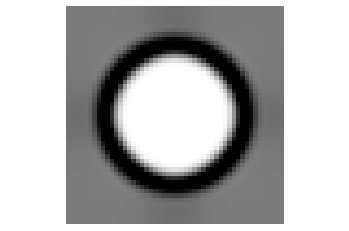

Loop:46 change :0.02136307079058286 mean_Density : 0.49999989554350677 Compliance :-0.47004601502810794


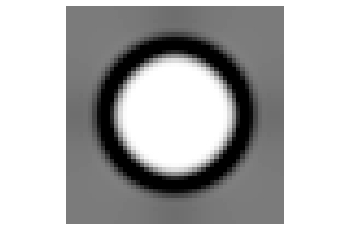

Loop:47 change :0.021263608050916316 mean_Density : 0.5000000704775212 Compliance :-0.4690735149085621


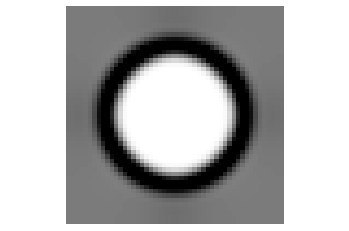

Loop:48 change :0.02051346413106747 mean_Density : 0.5000001387239117 Compliance :-0.46811940168843685


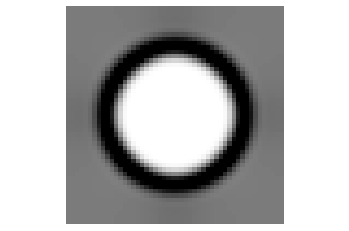

Loop:49 change :0.020782091628496424 mean_Density : 0.5000000438803263 Compliance :-0.4672109289984675


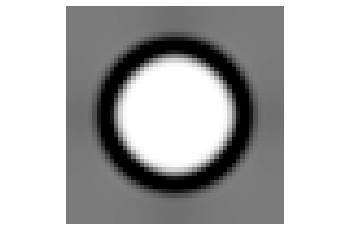

Loop:50 change :0.02102388946576139 mean_Density : 0.5000000099757587 Compliance :-0.4663310562831115


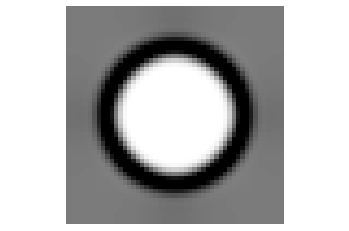

Loop:51 change :0.02085908165503103 mean_Density : 0.4999999379001538 Compliance :-0.46545504179662395


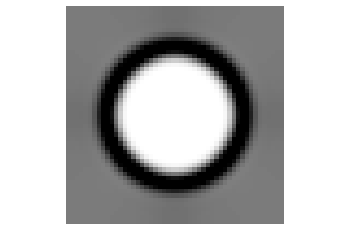

Loop:52 change :0.02092501148324255 mean_Density : 0.4999999822169224 Compliance :-0.46458829580327854


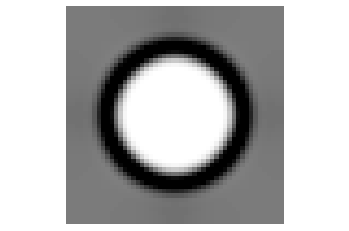

Loop:53 change :0.021015243967043684 mean_Density : 0.5000000900288519 Compliance :-0.46367787867434646


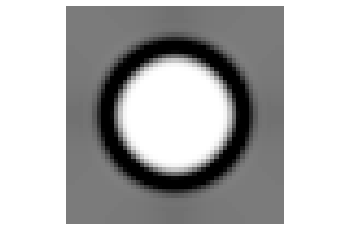

Loop:54 change :0.020431565857675138 mean_Density : 0.5000001036686779 Compliance :-0.4627763073487264


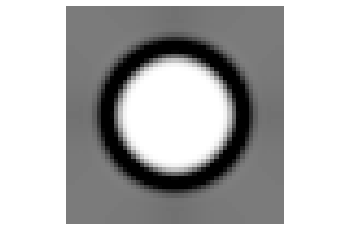

Loop:55 change :0.0200021913675138 mean_Density : 0.5000000855518698 Compliance :-0.46190551659439044


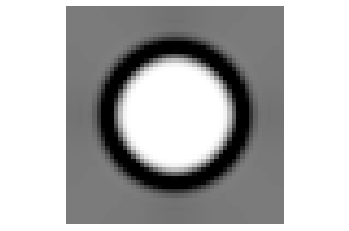

Loop:56 change :0.019746332959420743 mean_Density : 0.4999998517492995 Compliance :-0.4610004287928665


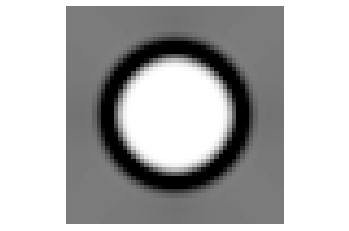

Loop:57 change :0.019089626464313336 mean_Density : 0.4999998417841269 Compliance :-0.46008186878910007


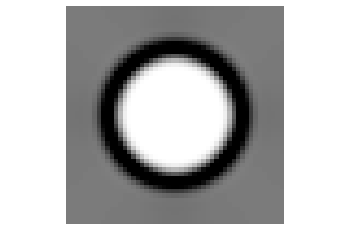

Loop:58 change :0.01904095711840903 mean_Density : 0.49999997654173184 Compliance :-0.4591484680760808


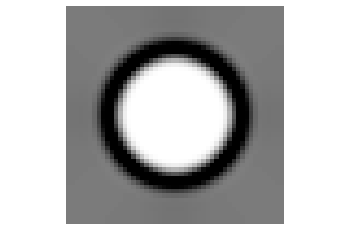

Loop:59 change :0.01933101008740712 mean_Density : 0.5000000287561799 Compliance :-0.45820118555947076


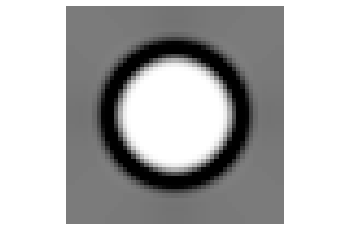

Loop:60 change :0.01907162787665717 mean_Density : 0.49999985636833355 Compliance :-0.4572405658197082


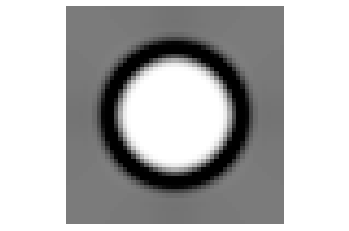

Loop:61 change :0.018820874338661198 mean_Density : 0.5000001239011077 Compliance :-0.4563020146334432


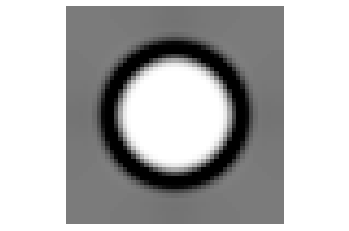

Loop:62 change :0.01807257692580999 mean_Density : 0.5000000525788508 Compliance :-0.4553650753806618


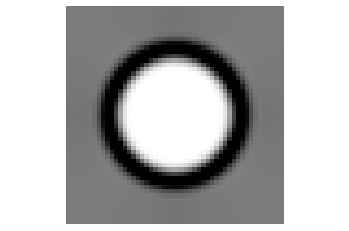

Loop:63 change :0.017538391391908936 mean_Density : 0.4999998622188768 Compliance :-0.4544425221878836


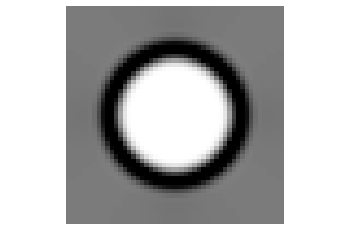

Loop:64 change :0.01700354523392178 mean_Density : 0.49999996349569376 Compliance :-0.4535386252629458


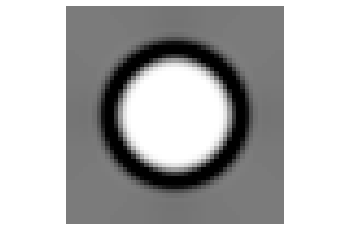

Loop:65 change :0.016571793559029713 mean_Density : 0.4999999811751624 Compliance :-0.4526770078057683


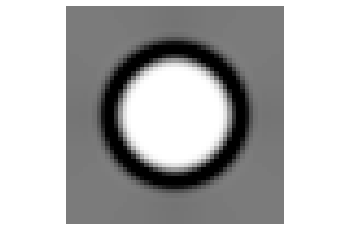

Loop:66 change :0.01612739482145531 mean_Density : 0.49999987073309676 Compliance :-0.45185714418837664


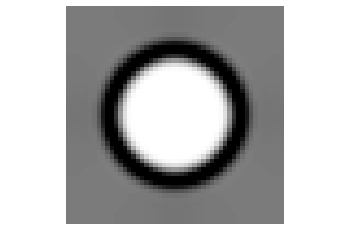

Loop:67 change :0.015718036912695466 mean_Density : 0.5000000440822366 Compliance :-0.45107997435524744


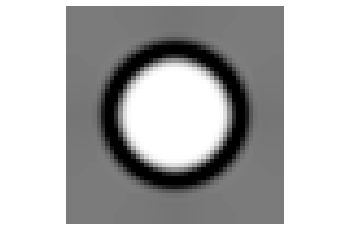

Loop:68 change :0.015497173202198011 mean_Density : 0.49999986096906507 Compliance :-0.45034734828622147


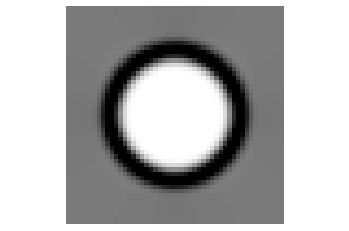

Loop:69 change :0.015230069033421945 mean_Density : 0.4999998344445068 Compliance :-0.449649753574592


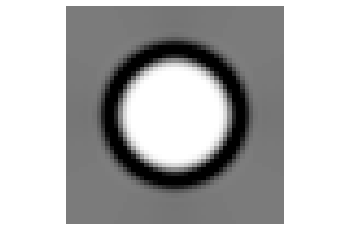

Loop:70 change :0.015249026094540818 mean_Density : 0.4999998756478375 Compliance :-0.4489826456357908


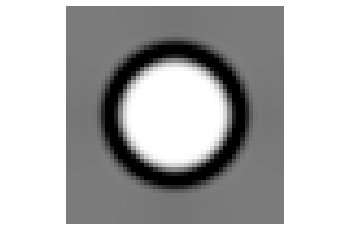

Loop:71 change :0.01602967666369015 mean_Density : 0.5000000091362452 Compliance :-0.4483103712245841


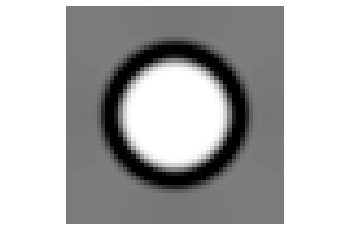

Loop:72 change :0.01606134756876265 mean_Density : 0.5000000162234616 Compliance :-0.4476576863872125


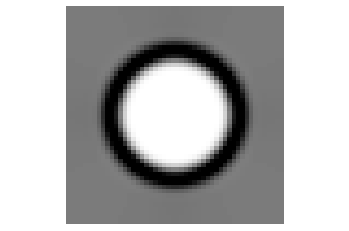

Loop:73 change :0.015548318717622411 mean_Density : 0.49999991058330195 Compliance :-0.4469983751903151


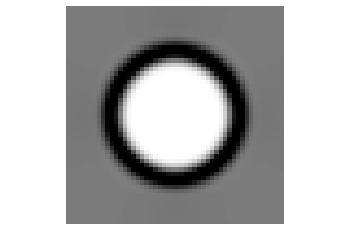

Loop:74 change :0.015136000910784708 mean_Density : 0.50000015991136 Compliance :-0.446341944576411


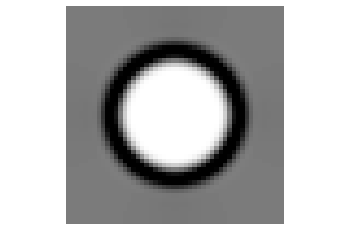

Loop:75 change :0.014936714806455975 mean_Density : 0.5000000678818585 Compliance :-0.4457016635260506


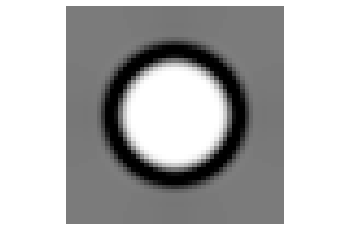

Loop:76 change :0.01461009365715038 mean_Density : 0.49999997871802726 Compliance :-0.44506346411791814


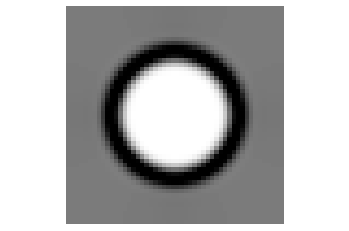

Loop:77 change :0.014668073892485145 mean_Density : 0.4999998736857824 Compliance :-0.4444031558560432


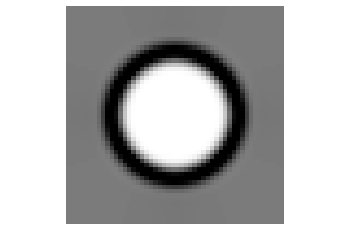

Loop:78 change :0.014912697957637167 mean_Density : 0.500000095446446 Compliance :-0.4437253157957154


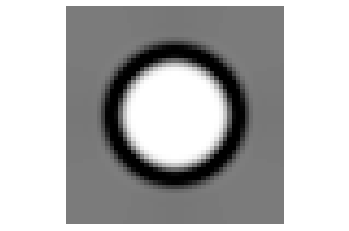

Loop:79 change :0.01474543212566426 mean_Density : 0.5000001024714932 Compliance :-0.44302122555098356


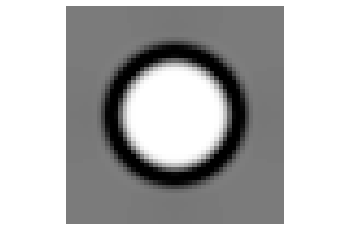

Loop:80 change :0.014769566098370879 mean_Density : 0.4999999003297142 Compliance :-0.4423160390855717


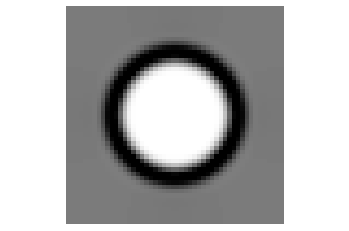

Loop:81 change :0.014793278677772248 mean_Density : 0.49999991889287104 Compliance :-0.44161862359053244


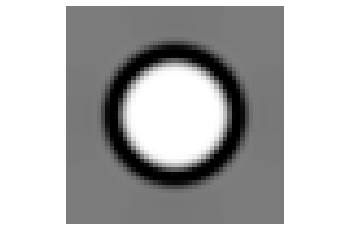

Loop:82 change :0.014975517241941572 mean_Density : 0.4999998376762966 Compliance :-0.44092106076795906


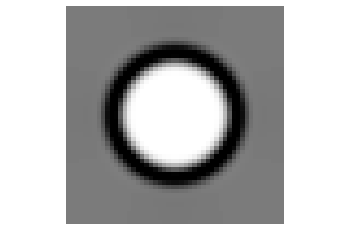

Loop:83 change :0.015020737176315135 mean_Density : 0.5000000727902181 Compliance :-0.440224079714856


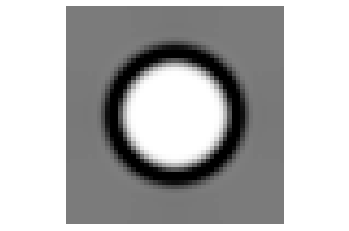

Loop:84 change :0.014543199991379874 mean_Density : 0.4999999938104402 Compliance :-0.4395507696593396


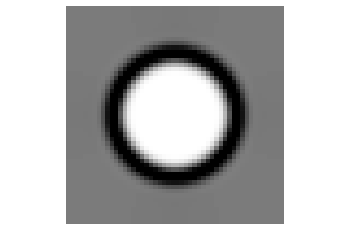

Loop:85 change :0.014656026463980343 mean_Density : 0.500000021599239 Compliance :-0.43887825971362765


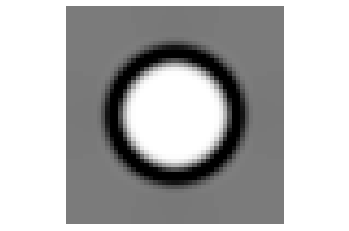

Loop:86 change :0.014445658321833643 mean_Density : 0.499999820648877 Compliance :-0.4382100397134794


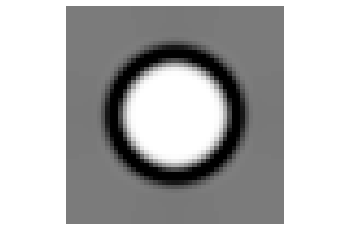

Loop:87 change :0.013906690615803519 mean_Density : 0.5000000352721357 Compliance :-0.437563138937354


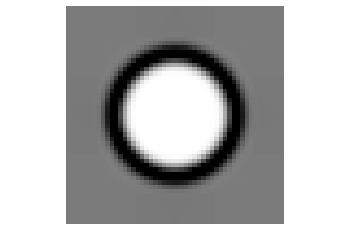

Loop:88 change :0.013358223368977407 mean_Density : 0.500000074417015 Compliance :-0.43694585659090096


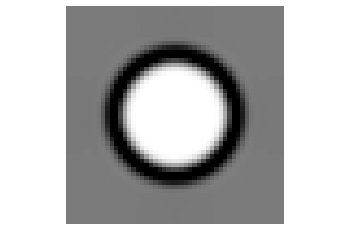

Loop:89 change :0.012828357593045792 mean_Density : 0.4999999030156752 Compliance :-0.4363534220510393


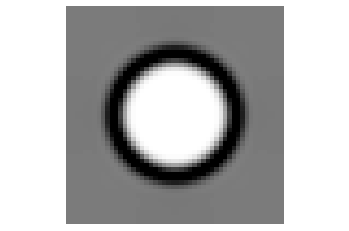

Loop:90 change :0.012201446421686635 mean_Density : 0.5000001484603452 Compliance :-0.43575505817852356


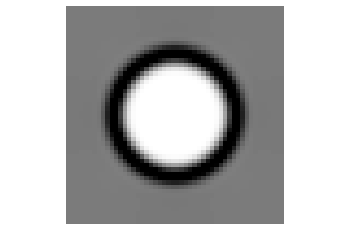

Loop:91 change :0.012055133152922504 mean_Density : 0.5000001196711186 Compliance :-0.4351537970699908


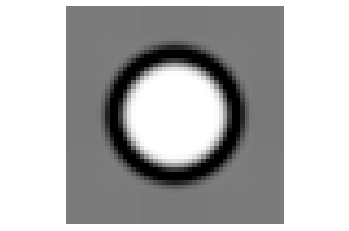

Loop:92 change :0.011854468125775286 mean_Density : 0.49999998449247396 Compliance :-0.4345609257750417


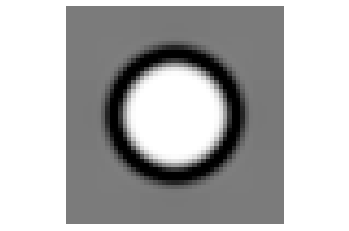

Loop:93 change :0.011725472746825338 mean_Density : 0.49999983038627277 Compliance :-0.43398521762701037


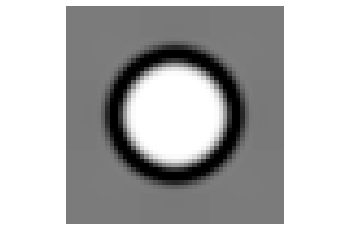

Loop:94 change :0.011652304002771507 mean_Density : 0.49999985396422336 Compliance :-0.43343054673374454


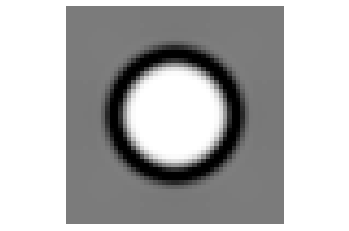

Loop:95 change :0.011538593043813883 mean_Density : 0.5000001666226761 Compliance :-0.43289868247214974


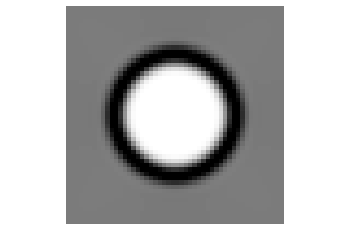

Loop:96 change :0.011382137304393525 mean_Density : 0.5000001005148086 Compliance :-0.4323887664350992


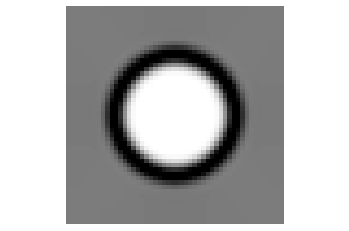

Loop:97 change :0.01119197588398435 mean_Density : 0.4999998638967094 Compliance :-0.431895268853946


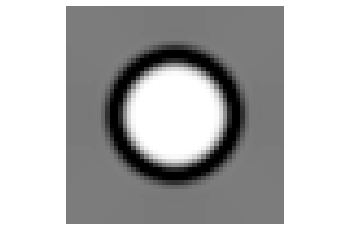

Loop:98 change :0.011013557911952354 mean_Density : 0.5000000465701061 Compliance :-0.4314189337354384


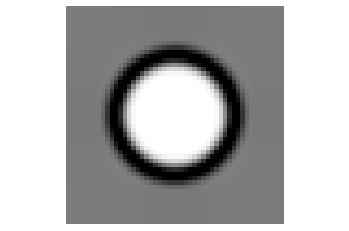

Loop:99 change :0.011039038967077808 mean_Density : 0.49999981939474153 Compliance :-0.43095514459192985


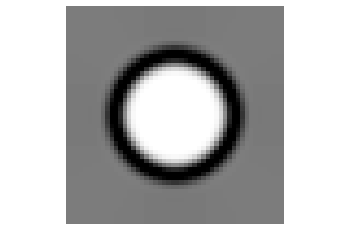

Loop:100 change :0.011119193096122748 mean_Density : 0.5000000127244149 Compliance :-0.4304967961410694


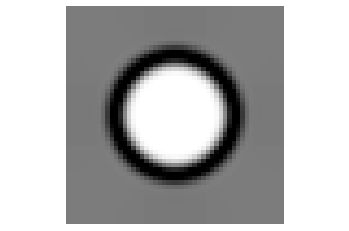

Loop:101 change :0.011191691082842015 mean_Density : 0.4999998918740308 Compliance :-0.43004109136997004


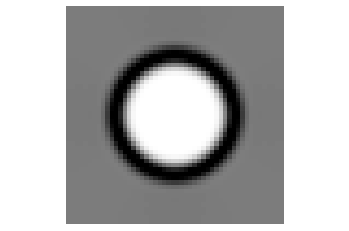

Loop:102 change :0.011210030366721635 mean_Density : 0.5000001820695976 Compliance :-0.42957136769199755


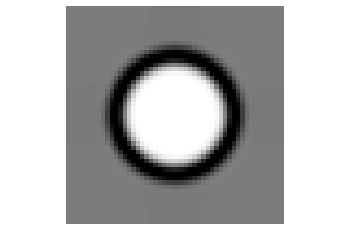

Loop:103 change :0.011249068549815333 mean_Density : 0.5000000718526721 Compliance :-0.4290891551823568


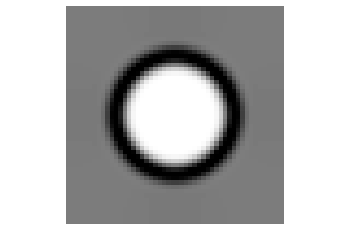

Loop:104 change :0.01132274380907361 mean_Density : 0.49999998985619043 Compliance :-0.428604742114156


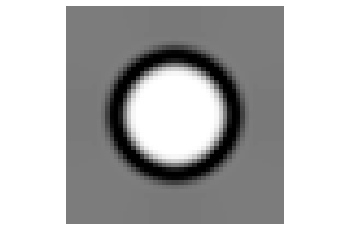

Loop:105 change :0.011295851828768688 mean_Density : 0.5000001779451863 Compliance :-0.4281276888137406


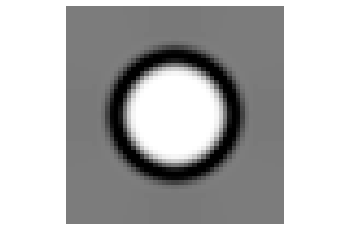

Loop:106 change :0.011178134183404631 mean_Density : 0.500000073487977 Compliance :-0.4276576784804422


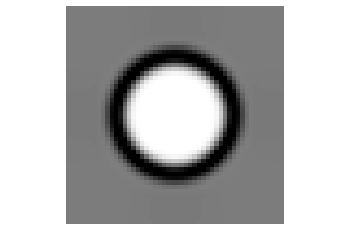

Loop:107 change :0.011120617257815879 mean_Density : 0.5000001602589533 Compliance :-0.42719358177665656


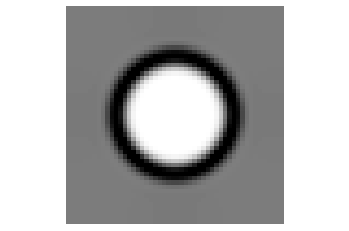

Loop:108 change :0.010946773702530277 mean_Density : 0.4999998242827456 Compliance :-0.4267236639433436


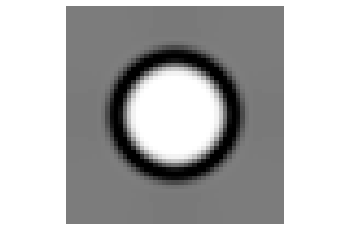

Loop:109 change :0.01089628417504307 mean_Density : 0.5000000256544092 Compliance :-0.42625178721056667


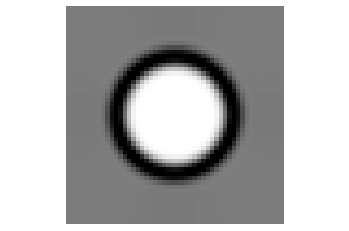

Loop:110 change :0.010680392718109166 mean_Density : 0.5000001184919489 Compliance :-0.4257709142401854


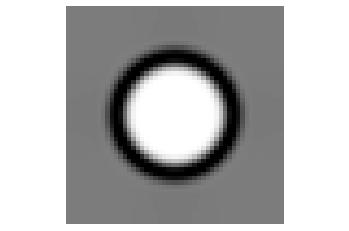

Loop:111 change :0.010656460883605834 mean_Density : 0.49999993409303245 Compliance :-0.4252932968473803


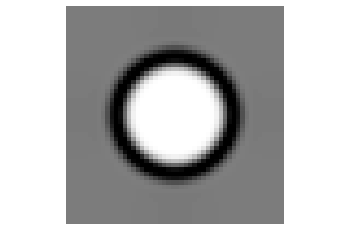

Loop:112 change :0.010682302752867301 mean_Density : 0.5000001464077722 Compliance :-0.42482190631908295


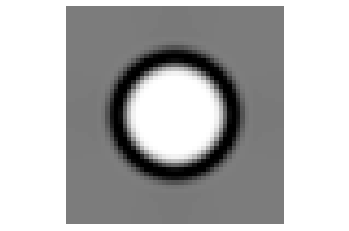

Loop:113 change :0.010695751799250863 mean_Density : 0.5000000440288068 Compliance :-0.42435742262991855


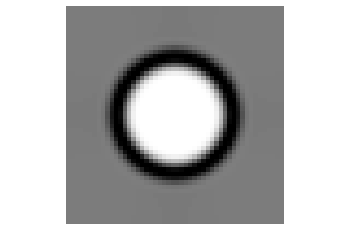

Loop:114 change :0.01057533925626053 mean_Density : 0.5000000505354663 Compliance :-0.423890611267977


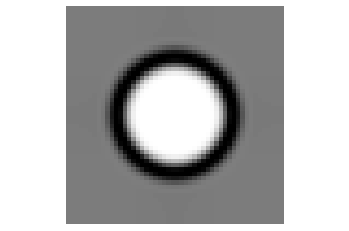

Loop:115 change :0.010531030776226302 mean_Density : 0.4999999318181739 Compliance :-0.4234324981293713


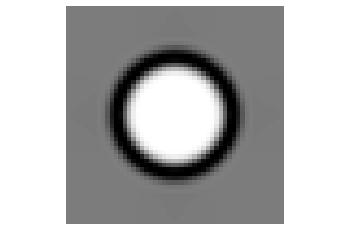

Loop:116 change :0.010379517270318939 mean_Density : 0.5000000050562664 Compliance :-0.4229824446644722


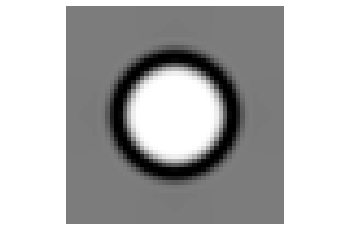

Loop:117 change :0.01024693324272452 mean_Density : 0.5000000372083974 Compliance :-0.42254214578035604


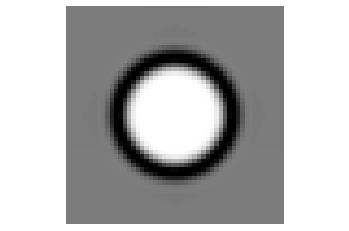

Loop:118 change :0.010071821794724767 mean_Density : 0.5000001522869976 Compliance :-0.42211259213343355


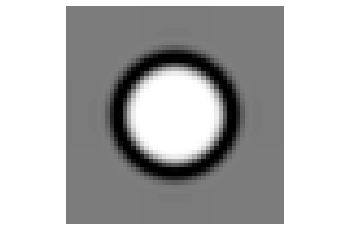

Loop:119 change :0.009855623043945272 mean_Density : 0.4999999232663624 Compliance :-0.4216960654898397


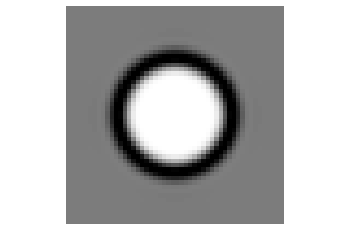

In [6]:
Nx=50;Ny=50
nu=0.3
Eo=1
Emin=1e-9
penal=3
volfrac=0.5
rmin=3
ft=1
# Generation of Input data

Node_matrix,Element_DOF,H_element=input_data(Nx,Ny,rmin)


# Generation of initial density
density=initial_Density(Nx,Ny,volfrac)

# Generation of element stiffness matrix
K_local=Stiffness_local(nu)

# Generation of  DOF for analysis(D1,D2,D3,D4)
D1,D2,D3,D4=BC(Node_matrix,Element_DOF)

# Generation of PBC and values for U_fixed and W_fixed
U_fixed,W_fixed=PBC(Nx,Ny)

# Iteration starts here
loop=0
change=1

while change >=0.01:
    
    loop=loop+1
    
    # Generation of Assembly stiffness matrix

    K_G=Global_Stifffness(K_local, Element_DOF,Node_matrix,density)
    
    # FE analysis of the periodic material
    disp=analysis(U_fixed,W_fixed,D1,D2,D3,D4,K_G)

    # calculation of compliance and their derivative
    C,dC,dV=strain_energy(disp,Element_DOF,density)

    # Applying filters/modification to sensivity analysis
    dC_filtered,dV_filtered=filteration(dC,dV,H_element,density)

    #Applying  Optimal criteria method to update physical variables
    density_new=optimal_criteria(dC_filtered,dV_filtered,density,H_element)

    # Evaluating the change between new and old density

    change=np.max(np.abs(density-density_new))
    density=density_new.copy()
    
    print(f"Loop:{loop} change :{change} mean_Density : { np.mean(density)} Compliance :{C}")
    
    # Plot the densities of all the elements
    plt.imshow(1-density_new, cmap='gray', vmin=0, vmax=1)
    plt.axis('equal')
    plt.axis('off')
    plt.show()

